## 1. 최적화 개념

## 2. 간단한 최적화 코드 예시

## 3. 포트폴리오 최적화

## 4. MVO 최적화 코드 3가지


## 1. 최적화 개념

#### Optimization
* Optimization is the process of making a trading system more effective by adjusting the variables used for technical analysis. A trading system can be optimized by reducing certain transaction costs or risks, or by targeting assets with greater expected returns.

금융에서 최적화는 위와 같은 의미를 지닌다.

<br>

* 수식적으로는 제약조건을 만족시키면서, 목적함수를 최대화, 최소화하는 변수를 찾는 과정이라 이해할 수 있다.

## 2. 간단한 최적화 코드 예시

In [1]:
from scipy.optimize import minimize
import numpy as np

# 목적함수 정의
fun = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2

# 제약식 정의
cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
        {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6})

# 변수 범위 정의
bnds = ((0, None), (0, None))

res = minimize(fun, (2, 0), method='SLSQP', bounds=bnds,
               constraints=cons)

x[0] = x, x[1] = y라고 생각한다면

* 목적함수
<br> (x-1)^2 + (y-2)^2 값을 최소화하는 것이다.

* 제약식 <br>
x-2y+2 >= 0, <br> -x-2y+6 >= 0

* 변수 범위 <br>
x, y 둘 다 0~∞

<br>

scipy의 minimiza 함수를 통해 위와 같이 최적화를 진행하면 아래와 같이 success에 True가 나온다.
<br>

즉 주어진 제약조건 하에 최적 해를 찾는 것에 성공했다는 것이고, x값에 최적 값이 저장된다.



In [2]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.20000000000000256
       x: [ 1.200e+00  1.600e+00]
     nit: 2
     jac: [ 4.000e-01 -8.000e-01]
    nfev: 6
    njev: 2

## 3. 포트폴리오 최적화

* Portfolios can be optimized by reducing risks, increasing expected returns, or changing the frequency of rebalancing.

* Each optimization depends upon a certain number of assumptions about real-world variables. For example, an investor seeking to optimize their portfolio would begin by assessing factors such as market risk and the likelihood that certain investments may outperform others. Since there is no way to calculate these variables in real time, the investor's optimization strategy would depend upon how well they estimate these factors.

1,3 개념 출처: [Optimization: Overview and Examples in Technical Analysis](https://www.investopedia.com/terms/o/optimization.asp))

* 1. 목표 기대수익률 이상의 제약조건 하에 분산을 최소화하는 비중을 찾는 최적화

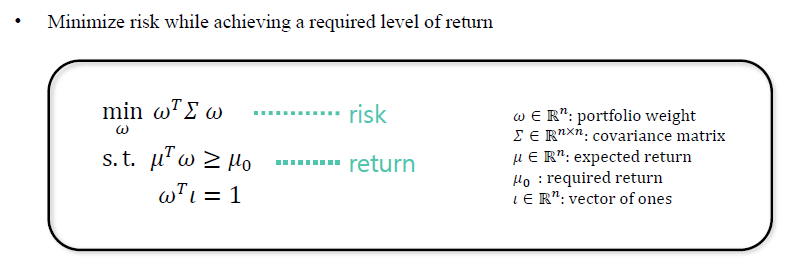

* 2. 목표 분산 이하의 제약조건 하에 수익률을 최대화하는 최적화

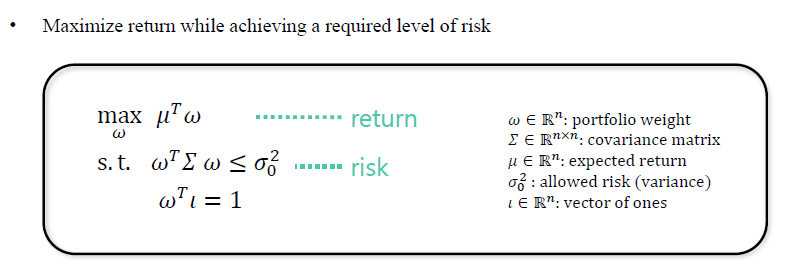

* 3. 리스크와 수익률을 적정하게 고려한 최적화

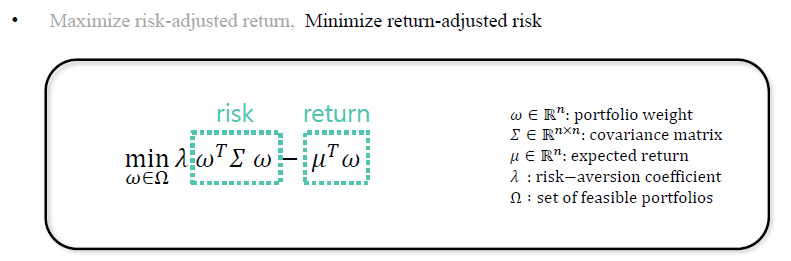

수식 출처: 경희대학교 김장호 교수님 - 자산운용을 위한 금융최적화 ppt

## 4. 포트폴리오 최적화 코드

In [3]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import cvxpy as cp
import scipy as sp
import cvxopt as cpt
from cvxopt import matrix, solvers
import statsmodels.api as sm
import math

In [4]:
!pip install -U finance-datareader
import FinanceDataReader as fdr

In [5]:
# 주가 데이터 불러오기

def get_data(start, end):
  ticker = ['005930','003670','000660','207940','006400','051910','005380','000270','005490','035420'] # 시가총액 상위 10개 (LG에너지솔루션 제외)
  asset = pd.DataFrame()
  for t in ticker:
    asset[t] = fdr.DataReader(t, start, end)['Close']
  asset_pct = asset.pct_change()
  asset_pct = asset_pct.dropna()
  return asset, asset_pct

start = '2018-01-01'
end = '2022-12-31'
asset, asset_pct = get_data(start, end)

In [6]:
asset.isnull().sum() # Nan 값 확인

005930    0
003670    0
000660    0
207940    0
006400    0
051910    0
005380    0
000270    0
005490    0
035420    0
dtype: int64

In [7]:
asset_pct

,005930,003670,000660,207940,006400,051910,005380,000270,005490,035420
Date,,,,,,,,,,
2018-01-03,0.011760,-0.025912,0.014360,0.003853,-0.021226,-0.003650,0.006689,-0.006098,0.054572,-0.015819
2018-01-04,-0.010461,-0.039295,-0.007722,-0.020459,0.004819,-0.034188,-0.026578,-0.032209,0.027972,0.025257
2018-01-05,0.020360,0.076519,0.028534,0.018277,0.057554,0.024020,0.017065,0.012678,0.001361,0.016796
2018-01-08,-0.001919,-0.020838,-0.013871,0.024357,0.022676,0.048148,0.013423,0.014085,0.004076,0.046256
2018-01-09,-0.031142,0.007521,-0.016624,0.022529,-0.026608,0.002356,0.009934,0.003086,0.021651,-0.006312
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.016920,-0.055556,-0.017677,-0.021845,-0.023548,-0.025559,-0.009464,-0.012598,-0.003454,-0.035230
2022-12-26,-0.003442,0.033613,-0.010283,0.019851,0.003215,0.013115,0.006369,0.015949,0.012132,0.002809
2022-12-27,0.003454,0.024390,0.000000,0.007299,0.000000,0.016181,0.000000,0.006279,0.000000,0.014006


In [8]:
exp_return = asset_pct.mean()
exp_ann = exp_return*250
exp_cov = asset_pct.cov()
cov_ann = exp_cov*250

### Optimization: Method SLSQP <br>
uses Sequential Least SQuares Programming to minimize a function of several variables with any combination of bounds, equality and inequality constraints. The method wraps the SLSQP Optimization subroutine originally implemented by Dieter Kraft [12]. Note that the wrapper handles infinite values in bounds by converting them into large floating values.

#### 아래 최적화는 위에서 가져온 시가총액 10개 기업으로 구성한 간단한 포트폴리오 최적화 예시이다.

#### 최적화 방법에 따라 3가지 방법의 코드로 구현했다.

### 수식1: 기대수익률 이상의 포트폴리오 중 최소 분산인 포트폴리오

In [9]:
def obj_1(w):
  return w.T @ cov_ann @ w
# 20% 변수 지정
def opt_1(w):
  w0 =  [1/len(w.columns) for i in range(len(w.columns))]
  bound = (0, 1) # 공매도 제한
  bounds = tuple(bound for i in range(len(w0))) # weight 는 0~1 사이 값
  con = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, {'type':'ineq', 'fun':lambda w: w.T@exp_ann - 0.20/252}] # 제약조건1은 같지 않으므로 ineq
  res = minimize(obj_1, w0, bounds= bounds, constraints= con, method = 'SLSQP')
  return res

res_1 = opt_1(asset_pct)

In [10]:
def obj_short(w):
  return w.T @ cov_ann @ w

def opt_short(w):
  w0 =  [1/len(w.columns) for i in range(len(w.columns))]
  bound = (-math.inf, math.inf) # 공매도 가능
  bounds = tuple(bound for i in range(len(w0))) # weight 는 0~1 사이 값
  con = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, {'type':'ineq', 'fun':lambda w: w.T@exp_ann - 0.20/252}] # 제약조건1은 같지 않으므로 ineq
  res = minimize(obj_1, w0, bounds= bounds, constraints= con, method = 'SLSQP')
  return res

res_1 = opt_1(asset_pct)

In [11]:
np.set_printoptions(suppress=True)
res_1.x

array([0.35575571, 0.02730927, 0.        , 0.12690191, 0.00306573,
       0.        , 0.04151923, 0.11662368, 0.16970976, 0.15911471])

In [12]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.04380393987274724
       x: [ 3.558e-01  2.731e-02  0.000e+00  1.269e-01  3.066e-03
            5.963e-19  4.152e-02  1.166e-01  1.697e-01  1.591e-01]
     nit: 12
     jac: [ 8.773e-02  8.781e-02  9.280e-02  8.745e-02  8.806e-02
            8.874e-02  8.765e-02  8.754e-02  8.775e-02  8.731e-02]
    nfev: 132
    njev: 12

### 수식2: 기대분산 이하의 포트폴리오 중 최대 수익률인 포트폴리오

In [13]:
def obj_2(w):
  return -(w.T @ exp_ann)

def opt_2(w):
  w0 =  [1/len(w.columns) for i in range(len(w.columns))]
  bound = (0, 1)
  bounds = tuple(bound for i in range(len(w0))) # weight 는 0~1 사이 값
  con = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, {'type':'ineq', 'fun':lambda w: w.T @ cov_ann @ w - 0.3^2/252}] # 제약조건1은 같지 않으므로 ineq
  res = minimize(obj_1, w0, bounds= bounds, constraints= con, method = 'SLSQP')
  return res
#  보통 주식은 연 20~40% 변동성
res_2 = opt_1(asset_pct)

In [14]:
res_2.x

array([0.35575571, 0.02730927, 0.        , 0.12690191, 0.00306573,
       0.        , 0.04151923, 0.11662368, 0.16970976, 0.15911471])

### 수식3: 분산과 수익률을 lambda 값을 통해 조절한 포트폴리오

In [15]:
def obj_3(w):
  lam = 3
  return lam * w.T@cov_ann@w - (w.T @ exp_ann)

def opt_2(w):
  w0 =  [1/len(w.columns) for i in range(len(w.columns))]
  bound = (0, 1)
  bounds = tuple(bound for i in range(len(w0))) # weight 는 0~1 사이 값
  con = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}] # 제약조건1은 같지 않으므로 ineq
  res = minimize(obj_1, w0, bounds= bounds, constraints= con, method = 'SLSQP')
  return res

res_3 = opt_1(asset_pct)

In [16]:
res_3.x

array([0.35575571, 0.02730927, 0.        , 0.12690191, 0.00306573,
       0.        , 0.04151923, 0.11662368, 0.16970976, 0.15911471])